# 7/6 project 진행
---

이전 7/4 model 구축 project에서 굉장히 미숙한 부분이 많았다.  
우선 model을 inference할 때, 당시 코드의 실행에는 문제가 없었지만 model을 불러올 때 내가 저장한 model이 아닌 jupyter notebook에서 실행되고 있는 변수 모델인 FCN_model을 불러왔다는 점(의미 없는 변수를 만든 거나 마찬가지), 그리고 code를 수정하면서 이전에 실행하여 남아있는 변수인 accuracy가 그대로 남아있는 채로 새로운 accuracy를 출력하지 않고 이전 accuracy를 출력했다는 점이다. 이번 project에선 이러한 부분들을 우선 수정해보고 이전 모델을 다시 학습시켜보겠다.

## 학습에 필요한 data load하기

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv(r'D:\ML_final_project\data\preprocessed_data\preprocessing_train_2nd.csv')
test = pd.read_csv(r'D:\ML_final_project\data\preprocessed_data\preprocessing_test_2nd.csv')

## training에 필요한 module import 하기

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import to_categorical
from keras.callbacks.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

## Learning graph를 그려주는 함수

In [4]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, '-', label='Training acc')
    plt.plot(epochs, val_acc, '-', label='Validation acc')
    plt.legend()

    plt.subplot(122)
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, '-', label='Training loss')
    plt.plot(epochs, val_loss, '-', label='Validation loss')
    plt.legend()

    plt.show()

### dataset 구성하기

In [5]:
X = train.drop('Survived', axis=1).values
y = train['Survived'].values

In [6]:
y_one_hot = to_categorical(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### 실제 test set 구성하기

In [8]:
X_real_test = test.values

### dataset 확인하기

In [9]:
print('Training set shape :   ', 'X', X_train.shape, '|', 'y', y_train.shape)
print('Validation set shape : ', 'X', X_val.shape, ' |', 'y', y_val.shape)
print('Test set shape :       ', 'X', X_test.shape, ' |', 'y', y_test.shape)

Training set shape :    X (720, 6) | y (720, 2)
Validation set shape :  X (81, 6)  | y (81, 2)
Test set shape :        X (90, 6)  | y (90, 2)


### Model 구성하기

model은 각 feature들의 연관성을 찾고자 FCN으로 구성해보았다.  
Dense layer의 activation function은 relu로 설정했고, 마지막층인 output layer의 activation은 이 과제가 생존여부(0, 1)을 classification 하는 것이기 때문에 sigmoid로 설정했다.  
optimizer는 adam, loss function은 이진분류에 좋은 성능을 보이는 binary_crossentropy로 설정했다.

In [12]:
def FCN(input_size = (6,)): #인풋 사이즈 설정
    inputs = Input(input_size)
    
    dense1 = Dense(10, activation='relu')(inputs)
    dense2 = Dense(5, activation='relu')(dense1)
    dense3 = Dense(3, activation='relu')(dense2)
    
    outputs = Dense(2, activation='sigmoid')(dense3)
    
    model = Model(input = inputs, output = outputs)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    
    return model

In [13]:
FCN_model = FCN()
FCN_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 8         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


### Model hyperparmeter 설정하기

10 epoch 마다 model을 저장한다.  
저장된 모델은 나중에 다시 꺼내서 쓸 수도 있고, model test에도 사용될 것이다.

In [14]:
save_path = 'D:\ML_final_project\model' #model을 저장할 폴더 경로
num_batch = 16
num_epoch = 100
num_period = 10 #model을 저장하는 간격

In [15]:
checkpointer = ModelCheckpoint(save_path + '/' + 'm0706_' + '{epoch:04d}.hdf5',
                               monitor='val_loss',
                               period=num_period)

#### 아래 셀은 이번 project에는 사용하지 않겠다.

In [16]:
# early_stopping = EarlyStopping(monitor='val_loss',
#                                patience=10,
#                                mode='min')

### Model training 하기

In [17]:
FCN_histories = list()

FCN_history = FCN_model.fit(X_train, y_train,
                            validation_data=(X_val,y_val),
                            batch_size=num_batch,
                            epochs=num_epoch,
                            shuffle=True,
                            callbacks=[checkpointer])

FCN_histories.append(FCN_history)


Train on 720 samples, validate on 81 samples
Epoch 1/100
720/720 [==============================] - 0s 242us/step - loss: 0.7274 - acc: 0.6208 - val_loss: 0.7032 - val_acc: 0.5926
Epoch 2/100
720/720 [==============================] - 0s 45us/step - loss: 0.6766 - acc: 0.6208 - val_loss: 0.6743 - val_acc: 0.5926
Epoch 3/100
720/720 [==============================] - 0s 43us/step - loss: 0.6527 - acc: 0.6208 - val_loss: 0.6560 - val_acc: 0.5926
Epoch 4/100
720/720 [==============================] - 0s 44us/step - loss: 0.6345 - acc: 0.6222 - val_loss: 0.6411 - val_acc: 0.6049
Epoch 5/100
720/720 [==============================] - 0s 42us/step - loss: 0.6179 - acc: 0.6375 - val_loss: 0.6273 - val_acc: 0.6049
Epoch 6/100
720/720 [==============================] - 0s 44us/step - loss: 0.6027 - acc: 0.6507 - val_loss: 0.6147 - val_acc: 0.6235
Epoch 7/100
720/720 [==============================] - 0s 48us/step - loss: 0.5900 - acc: 0.6812 - val_loss: 0.6074 - val_acc: 0.6481
Epoch 8/100
720

Epoch 60/100
720/720 [==============================] - 0s 44us/step - loss: 0.4713 - acc: 0.8000 - val_loss: 0.4856 - val_acc: 0.8086
Epoch 61/100
720/720 [==============================] - 0s 46us/step - loss: 0.4705 - acc: 0.8021 - val_loss: 0.4824 - val_acc: 0.7716
Epoch 62/100
720/720 [==============================] - 0s 42us/step - loss: 0.4712 - acc: 0.7937 - val_loss: 0.4862 - val_acc: 0.8086
Epoch 63/100
720/720 [==============================] - 0s 43us/step - loss: 0.4705 - acc: 0.7965 - val_loss: 0.4880 - val_acc: 0.8148
Epoch 64/100
720/720 [==============================] - 0s 43us/step - loss: 0.4699 - acc: 0.7979 - val_loss: 0.4849 - val_acc: 0.8086
Epoch 65/100
720/720 [==============================] - 0s 46us/step - loss: 0.4695 - acc: 0.8014 - val_loss: 0.4846 - val_acc: 0.7963
Epoch 66/100
720/720 [==============================] - 0s 43us/step - loss: 0.4689 - acc: 0.8021 - val_loss: 0.4847 - val_acc: 0.8025
Epoch 67/100
720/720 [==============================] -

### Learning graph 나타내기

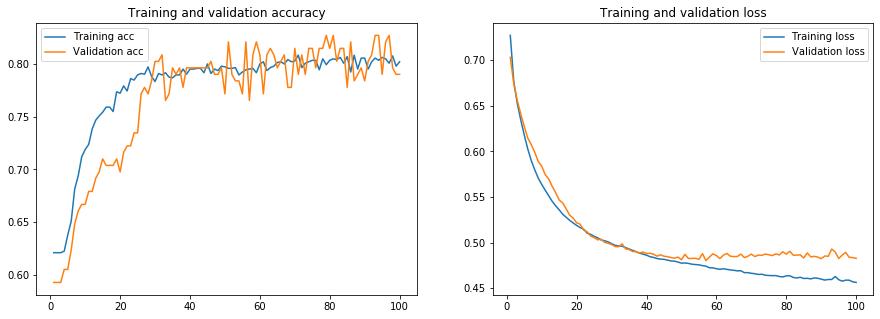

In [18]:
for idx, history in enumerate(FCN_histories):
    plot_learning_curve(history)

### Model test 하기

In [19]:
model_path = r'D:\ML_final_project\model\m0706_0100.hdf5'
model = load_model(model_path)

In [32]:
y_label = np.argmax(y_test, 1)
y_fit = np.argmax(model.predict(X_test), 1)
confusion_mat = confusion_matrix(y_label, y_fit)

print('y_true =', y_label)
print('y_pred =', y_fit)
print('-' * 50)
print('<confusion_mat>')
confusion_mat

y_true = [1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0]
y_pred = [0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1
 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0]
--------------------------------------------------
<confusion_mat>


array([[46,  8],
       [ 6, 30]], dtype=int64)

In [33]:
precision, recall, fscore, support = score(y_label, y_fit)
accuracy = accuracy_score(y_label,y_fit)

print('accuracy  :', accuracy)
print('recall    :', recall)
print('precision :', precision)
print('fscore    :', fscore)
print('support   :', support)

accuracy  : 0.8444444444444444
recall    : [0.85185185 0.83333333]
precision : [0.88461538 0.78947368]
fscore    : [0.86792453 0.81081081]
support   : [54 36]


---
## training에 사용되지 않은 data로 model inference 하기

kaggle 홈페이지에서 제공한 gender_submission이라는 csv파일을 갖고 model을 inference 해보겠다.

In [34]:
y_real_test = pd.read_csv('D:\ML_final_project\data\gender_submission.csv')

In [35]:
y_real_test.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [36]:
y_real_label_one_hot = to_categorical(y_real_test['Survived'])
y_real_label = np.argmax(y_real_label_one_hot, 1)
y_real_fit = np.argmax(model.predict(X_real_test), 1)
confusion_mat = confusion_matrix(y_real_label, y_real_fit)

print('y_true =', y_real_label)
print('y_pred =', y_real_fit)
print('-' * 50)
print('<confusion_mat>')
confusion_mat

y_true = [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]
y_pred = [0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1
 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1

array([[228,  38],
       [  4, 148]], dtype=int64)

지난 7월4일 model 구축 project에서 아래 셀을 실행할 때 restart를 하지 않아 이전 accuracy 변수가 남아있어 잘못된 accuracy가 출력이 되었다. 코드를 수정하면서 착오가 있었던 것 같다. 저번 model을 저장해두었기 때문에 다시 불러와서 model을 inference해보겠다. 일단 아래는 이번 project의 결과이다.

In [37]:
#7/6
precision, recall, fscore, support = score(y_real_label, y_real_fit)
accuracy = accuracy_score(y_real_label, y_real_fit)

print('accuracy  :', accuracy)
print('recall    :', recall)
print('precision :', precision)
print('fscore    :', fscore)
print('support   :', support)

accuracy  : 0.8995215311004785
recall    : [0.85714286 0.97368421]
precision : [0.98275862 0.79569892]
fscore    : [0.91566265 0.87573964]
support   : [266 152]


지난 project의 model이다.

In [29]:
model_path_0704 = r'D:\ML_final_project\model\m0704\m0704_0100.hdf5'
model_0704 = load_model(model_path_0704)

In [30]:
#7/4
y_real_label_one_hot = to_categorical(y_real_test['Survived'])
y_real_label = np.argmax(y_real_label_one_hot, 1)
y_real_fit = np.argmax(model_0704.predict(X_real_test), 1)
confusion_mat = confusion_matrix(y_real_label, y_real_fit)

print('y_true =', y_real_label)
print('y_pred =', y_real_fit)
print('-' * 50)
print('<confusion_mat>')
confusion_mat

y_true = [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]
y_pred = [0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1
 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1

array([[209,  57],
       [  5, 147]], dtype=int64)

In [31]:
precision, recall, fscore, support = score(y_real_label, y_real_fit)
accuracy = accuracy_score(y_real_label, y_real_fit)

print('accuracy  :', accuracy)
print('recall    :', recall)
print('precision :', precision)
print('fscore    :', fscore)
print('support   :', support)

accuracy  : 0.8516746411483254
recall    : [0.78571429 0.96710526]
precision : [0.97663551 0.72058824]
fscore    : [0.87083333 0.8258427 ]
support   : [266 152]


## Result

같은 FCN으로 model을 학습했지만 저번 model의 결과가 이번 결과보다 잘 나온 것은 가중치를 랜덤하게 부여할 때 저번 model이 조금 더 성능이 좋게 설정이 된 것 같다.  
7/4 model의 accuracy는 0.851  
7/6 model의 accuracy는 0.899  
가 나온 것을 확인할 수 있다.